# RQ5: Execution - How do the execution times of different coverage gap analysis tools compare?

- Collect the execution times for each of the 3 processes from the log files
- Add to table - Bold fastest execution
- Look at ways to compare the times.


In [5]:
import re
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

def read_project_list(path):
    project_list_path = path
    with open(project_list_path, "r") as project_list_csv:
        # read project csv
        csv_reader = csv.DictReader(project_list_csv)
        project_dict = [row for row in csv_reader]

        # import each active project
        project_list = []

        for project in project_dict:
            if project["active"] == "true".strip():
                project_list.append(project["name"])

        return project_list

def convert_time_to_seconds(time_str):
    match = re.match(r"(\d+)m(\d+\.\d+)s", time_str)
    if match:
        minutes, seconds = map(float, match.groups())
        return minutes * 60 + seconds
    else:
        return None

def extract_times_from_pit_logs(project_data_dir, csv_file, project_list):
    times = []
    for root, _, files in os.walk(project_data_dir):
        if "time.log" in files:
            directory = root
            project = os.path.basename(directory)
            if project not in project_list:
                continue
            log_file_path = os.path.join(root, "pit_time.log")
            with open(log_file_path, "r") as f:
                current_tool = "PIT"
                for line in f:
                    real_match = re.search(r"real\s+(\d+m\d+\.\d+s)", line)
                    user_match = re.search(r"user\s+(\d+m\d+\.\d+s)", line)
                    sys_match = re.search(r"sys\s+(\d+m\d+\.\d+s)", line)

                    if real_match:
                        times.append(
                            [
                                project,
                                current_tool,
                                "real",
                                convert_time_to_seconds(real_match.group(1)),
                            ]
                        )
                    elif user_match:
                        times.append(
                            [
                                project,
                                current_tool,
                                "user",
                                convert_time_to_seconds(user_match.group(1)),
                            ]
                        )
                    elif sys_match:
                        times.append(
                            [
                                project,
                                current_tool,
                                "sys",
                                convert_time_to_seconds(sys_match.group(1)),
                            ]
                        )
    with open(csv_file, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # writer.writerow(["project", "Tool", "time_type", "time"])
        writer.writerows(times)

def extract_times_from_logs(project_data_dir, csv_file, project_list):
    times = []
    for root, _, files in os.walk(project_data_dir):
        if "time.log" in files:
            directory = root
            project = os.path.basename(directory)
            if project not in project_list:
                continue
            log_file_path = os.path.join(root, "time.log")
            with open(log_file_path, "r") as f:
                current_tool = "unknown"
                for line in f:
                    if "cc-slicer4j" in line:
                        current_tool = "Slicer4J"
                    elif "pseudosweep" in line:
                        current_tool = "PseudoSweep"
                    elif "cc-orbs" in line:
                        current_tool = "PORBS"

                    real_match = re.search(r"real\s+(\d+m\d+\.\d+s)", line)
                    user_match = re.search(r"user\s+(\d+m\d+\.\d+s)", line)
                    sys_match = re.search(r"sys\s+(\d+m\d+\.\d+s)", line)

                    if real_match:
                        times.append(
                            [
                                project,
                                current_tool,
                                "real",
                                convert_time_to_seconds(real_match.group(1)),
                            ]
                        )
                    elif user_match:
                        times.append(
                            [
                                project,
                                current_tool,
                                "user",
                                convert_time_to_seconds(user_match.group(1)),
                            ]
                        )
                    elif sys_match:
                        times.append(
                            [
                                project,
                                current_tool,
                                "sys",
                                convert_time_to_seconds(sys_match.group(1)),
                            ]
                        )

    with open(csv_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["project", "Tool", "time_type", "time"])
        writer.writerows(times)


project_data_dir = "../project_data"
csv_file_path = "../project_data/extracted_times_from_logs.csv"
project_list = read_project_list("../resources/class_projects.csv")
extract_times_from_logs(project_data_dir, csv_file_path, project_list)
extract_times_from_pit_logs(project_data_dir, csv_file_path, project_list)

print(f"Times extracted from time.log files and saved to {csv_file_path}")

Times extracted from time.log files and saved to ../project_data/extracted_times_from_logs.csv


/var/folders/sl/yzy0v54s79q0hkrg6fzrf93h0000gn/T/ipykernel_20656/3566982518.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df["project"],y=df.loc[df['time_type'] == 'real', 'time'], hue=df['Tool'],ci=None)


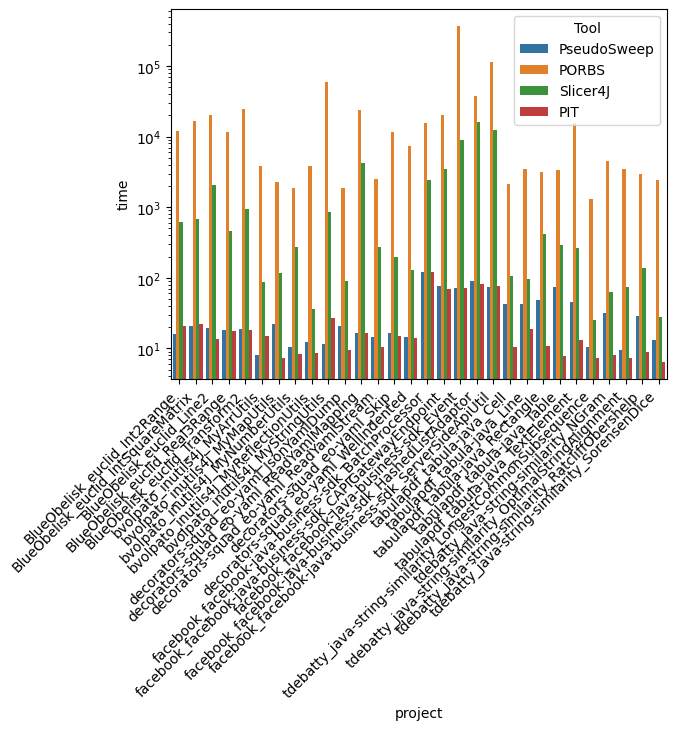

In [7]:
# plot times

df = pd.read_csv(csv_file_path)
df = df.sort_values('project', ascending = True).reset_index(drop=True)

sns.barplot(x=df["project"],y=df.loc[df['time_type'] == 'real', 'time'], hue=df['Tool'],ci=None)
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
# plt.savefig('/Users/meganm/Repos/Papers/cc-orbs-ps-paper/graphics/rq5-time-barplot.png', bbox_inches="tight")

              time
0.00  1.577000e+00
0.25  1.631200e+01
0.50  7.402900e+01
0.75  1.994336e+03
1.00  2.095668e+06


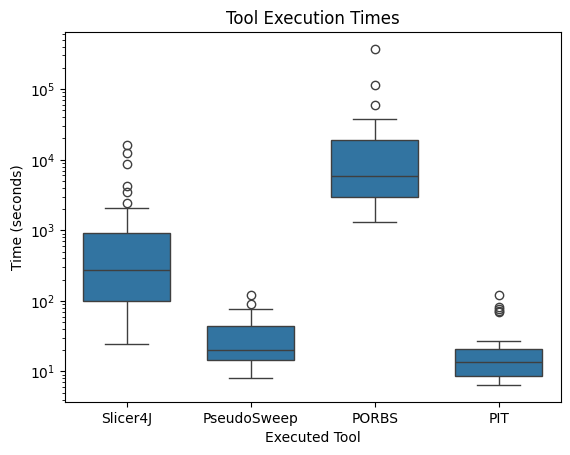

In [8]:
df = pd.read_csv(csv_file_path)
print(df.quantile(q=[0.0, 0.25, 0.5, 0.75, 1.0], axis=0, numeric_only=True))

# sns.boxplot(x=df.loc[df["Tool"]=="PIT", "Tool"],y=df.loc[df['time_type'] == 'real', 'time'],width=0.7)
# sns.boxplot(x=df.loc[df["Tool"]=="PseudoSweep", "Tool"],y=df.loc[df['time_type'] == 'real', 'time'],width=0.7)

sns.boxplot(x=df["Tool"], y=df.loc[df["time_type"] == "real", "time"], width=0.7)


plt.title("Tool Execution Times")

# plt.xticks(rotation=45, ha='right')
plt.xlabel("Executed Tool")

plt.ylabel("Time (seconds)")
plt.yscale("log")

plt.savefig(
    "/Users/meganmaton/Repos/Papers/cc-orbs-ps-paper/graphics/rq5-time-boxplot.png",
    bbox_inches="tight",
)

In [9]:
atonquartiles = df.loc[df['time_type'] == 'real', 'time'].quantile(q=[0.0, 0.25, 0.5, 0.75, 1.0])
print(quartiles)

for tool in df["Tool"].unique():
    print(f"Tool: {tool}")
    tool_df = df[df["Tool"] == tool]
    print(tool_df.loc[tool_df['time_type'] == 'real', 'time'].quantile(q=[0.0, 0.25, 0.5, 0.75, 1.0]))
    print("\n")

NameError: name 'quartiles' is not defined